In [17]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import xgboost as xgb
from sklearn.metrics import mean_squared_error

from src.features.data_engineering import preprocess_seasons_data
from src.features.data_engineering import reverse_processing

# Train 4 and 2 different models on the data with players separated by positions
- 4 models where players are separated by positions (GK, DEF, MID, FWD)
- 2 models where players are separated by positions (GK, FIELD_PLAYERS)

**NOTE:** Since XGBoost and MLP models had the best results for other baseline models (with other types of data), I decided to only use them in this notebook.

#### Load data

In [2]:
# load data by position
data_intermediate_path = os.path.dirname(os.getcwd()) + '\\data\\intermediate\\'

data_gk = pd.read_csv(data_intermediate_path + 'separate/gk.csv')
data_def = pd.read_csv(data_intermediate_path + 'separate/def.csv')
data_mid = pd.read_csv(data_intermediate_path + 'separate/mid.csv')
data_fwd = pd.read_csv(data_intermediate_path + 'separate/fwd.csv')

In [3]:
rolling_columns_gk = ['bonus', 'bps', 'clean_sheets', 'goals_conceded', 'influence', 'minutes',
                      'penalties_saved', 'saves', 'selected', 'player_team_score', 'opponent_team_score',
                      'total_points', 'transfers_in', 'transfers_out','value']

rolling_columns_def = ['assists', 'bonus', 'bps', 'clean_sheets', 'creativity', 'goals_conceded', 'goals_scored',
                       'ict_index', 'influence', 'minutes', 'selected', 'player_team_score', 'opponent_team_score',
                       'threat', 'total_points', 'transfers_in', 'transfers_out', 'value', 'yellow_cards']

rolling_columns_mid = ['assists', 'bonus', 'bps', 'clean_sheets', 'creativity', 'goals_conceded', 'goals_scored',
                       'ict_index', 'influence', 'minutes', 'selected', 'player_team_score', 'opponent_team_score',
                       'threat', 'total_points', 'transfers_in', 'transfers_out', 'value', 'yellow_cards']

rolling_columns_fwd = ['assists', 'bonus', 'bps', 'creativity', 'goals_scored', 'ict_index', 'influence',
                       'minutes', 'selected', 'player_team_score', 'opponent_team_score', 'threat',
                       'total_points', 'transfers_in', 'transfers_out', 'value', 'yellow_cards']

In [4]:
times = ['all', 6, 3]

In [5]:
(x_train_gk, y_train_gk), (x_test_gk, y_test_gk), (x_train_target_gk, x_test_target_gk), x_scaler_gk = preprocess_seasons_data(data_gk, rolling_features=True, rolling_columns=rolling_columns_gk, rolling_times=times, opponent_team_stats=True, encode_position=False)

(x_train_def, y_train_def), (x_test_def, y_test_def), (x_train_target_def, x_test_target_def), x_scaler_def = preprocess_seasons_data(data_def, rolling_features=True, rolling_columns=rolling_columns_def, rolling_times=times, opponent_team_stats=True, encode_position=False)

(x_train_mid, y_train_mid), (x_test_mid, y_test_mid), (x_train_target_mid, x_test_target_mid), x_scaler_mid = preprocess_seasons_data(data_mid, rolling_features=True, rolling_columns=rolling_columns_mid, rolling_times=times, opponent_team_stats=True, encode_position=False)

(x_train_fwd, y_train_fwd), (x_test_fwd, y_test_fwd), (x_train_target_fwd, x_test_target_fwd), x_scaler_fwd = preprocess_seasons_data(data_fwd, rolling_features=True, rolling_columns=rolling_columns_fwd, rolling_times=times, opponent_team_stats=True, encode_position=False)

### 4 models (GK, DEF, MID, FWD)

In [6]:
def train_baseline_mlp(x_train, y_train, x_test, y_test, x_train_target, x_test_target, x_scaler):
    model_mlp = tf.keras.models.Sequential()

    model_mlp.add(tf.keras.layers.Dense(units=128, activation='relu', input_shape=(x_train.shape[1],)))
    model_mlp.add(tf.keras.layers.Dense(units=64, activation='relu'))
    model_mlp.add(tf.keras.layers.Dense(units=1, activation='linear'))

    model_mlp.compile(optimizer='adam', loss='mse')

    history = model_mlp.fit(x_train, y_train,
                            batch_size=16,
                            epochs=20,
                            validation_split=0.3)

    score = model_mlp.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score)

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    y_pred_mlp = pd.Series(model_mlp.predict(x_test).reshape(-1,), index=y_test.index, name='predicted_total_points_next_gameweek')

    x_test_reversed = reverse_processing(x_test, x_scaler, x_test_target)
    predictions_mlp = pd.concat([y_pred_mlp, x_test_reversed], axis=1)
    #return predictions_mlp sorted by predicted total points descending
    return predictions_mlp.sort_values(by='predicted_total_points_next_gameweek', ascending=False)

### Train baseline MLP models

Epoch 1/20
492/492 [==============================] - 1s 1ms/step - loss: 3.0562 - val_loss: 3.0759
Epoch 2/20
492/492 [==============================] - 0s 946us/step - loss: 2.9594 - val_loss: 3.0852
Epoch 3/20
492/492 [==============================] - 0s 902us/step - loss: 2.9560 - val_loss: 3.0891
Epoch 4/20
492/492 [==============================] - 0s 905us/step - loss: 2.9488 - val_loss: 3.0253
Epoch 5/20
492/492 [==============================] - 0s 827us/step - loss: 2.9341 - val_loss: 3.0173
Epoch 6/20
492/492 [==============================] - 0s 836us/step - loss: 2.9111 - val_loss: 3.0644
Epoch 7/20
492/492 [==============================] - 0s 843us/step - loss: 2.9054 - val_loss: 3.0399
Epoch 8/20
492/492 [==============================] - 0s 840us/step - loss: 2.8930 - val_loss: 3.1579
Epoch 9/20
492/492 [==============================] - 0s 831us/step - loss: 2.9184 - val_loss: 3.0363
Epoch 10/20
492/492 [==============================] - 0s 829us/step - loss: 2.8687 

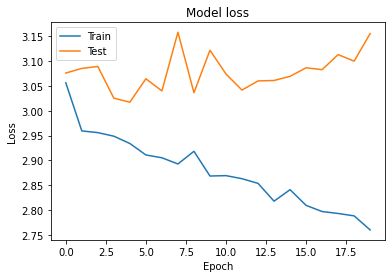

In [7]:
predictions_mlp_gk = train_baseline_mlp(x_train_gk, y_train_gk, x_test_gk, y_test_gk, x_train_target_gk, x_test_target_gk, x_scaler_gk)

In [8]:
predictions_mlp_gk.head(10)

,predicted_total_points_next_gameweek,name,GW,element,total_points_next_gameweek,season,bonus,bonus-3,bonus-6,bonus-all,...,opponent_next_G,opponent_next_GA,opponent_next_xG,opponent_next_NPxG,opponent_next_xGA,opponent_next_NPxGA,opponent_next_NPxGD,opponent_next_DC,opponent_next_ODC,opponent_next_xPTS
13606,5.072001,Kasper Schmeichel,20,200,2.0,2021-22,3.0,1.000000,0.500000,0.277778,...,1.857143,0.571429,2.232857,2.124286,0.777143,0.777143,1.347143,8.000000,6.428571,2.342857
13178,4.832599,Tim Krul,13,314,2.0,2021-22,0.0,0.000000,0.333333,0.307692,...,1.142857,2.142857,0.712857,0.712857,1.805714,1.588571,-0.875714,3.000000,8.714286,0.625714
9865,4.638776,Nick Pope,5,96,2.0,2020-21,3.0,1.000000,0.750000,0.750000,...,3.000000,1.600000,2.274000,2.122000,1.372000,0.916000,1.206000,5.400000,4.600000,1.892000
9099,4.631267,Nick_Pope_93,41,93,2.0,2019-20,2.0,1.666667,1.666667,0.687500,...,0.000000,2.000000,0.306667,0.306667,2.000000,2.000000,-1.696667,2.666667,6.666667,0.303333
9071,4.585200,Nick_Pope_93,40,93,9.0,2019-20,3.0,1.000000,1.333333,0.645161,...,1.000000,2.000000,0.425000,0.425000,1.465000,1.465000,-1.040000,2.000000,10.000000,0.915000
11538,4.549376,Illan Meslier,28,213,3.0,2020-21,3.0,1.666667,1.166667,0.678571,...,0.615385,0.923077,1.057692,1.057692,1.274615,1.216154,-0.158462,6.461538,5.153846,1.220769
5990,4.517589,Neil_Etheridge_88,22,88,2.0,2018-19,3.0,2.000000,1.500000,0.636364,...,0.700000,1.600000,0.821000,0.821000,1.703000,1.627000,-0.806000,4.500000,8.000000,0.803000
9281,4.485698,Aaron_Ramsdale_494,43,494,3.0,2019-20,0.0,0.000000,0.000000,0.294118,...,1.200000,0.800000,1.314000,1.314000,1.016000,0.712000,0.602000,6.600000,4.000000,1.514000
7349,4.448072,Ederson_Santana de Moraes_212,6,212,4.0,2019-20,0.0,0.000000,0.000000,0.000000,...,0.833333,1.500000,1.261667,1.261667,1.138333,1.138333,0.123333,7.166667,4.000000,1.460000
59,4.397923,Wayne_Hennessey,2,100,0.0,2016-17,0.0,0.000000,0.000000,0.000000,...,0.500000,2.000000,0.460000,0.460000,1.800000,1.800000,-1.345000,5.000000,8.500000,0.345000


Epoch 1/20
1536/1536 [==============================] - 1s 849us/step - loss: 4.8810 - val_loss: 4.9608
Epoch 2/20
1536/1536 [==============================] - 1s 862us/step - loss: 4.8137 - val_loss: 4.7431
Epoch 3/20
1536/1536 [==============================] - 1s 868us/step - loss: 4.7844 - val_loss: 4.7551
Epoch 4/20
1536/1536 [==============================] - 2s 1ms/step - loss: 4.7787 - val_loss: 4.7476
Epoch 5/20
1536/1536 [==============================] - 1s 865us/step - loss: 4.7696 - val_loss: 4.9122
Epoch 6/20
1536/1536 [==============================] - 1s 841us/step - loss: 4.7664 - val_loss: 4.7299
Epoch 7/20
1536/1536 [==============================] - 1s 836us/step - loss: 4.7530 - val_loss: 4.7963
Epoch 8/20
1536/1536 [==============================] - 1s 835us/step - loss: 4.7429 - val_loss: 4.7436
Epoch 9/20
1536/1536 [==============================] - 1s 859us/step - loss: 4.7410 - val_loss: 4.7568
Epoch 10/20
1536/1536 [==============================] - 1s 803us/

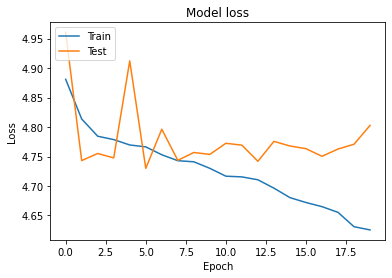

In [9]:
predictions_mlp_def = train_baseline_mlp(x_train_def, y_train_def, x_test_def, y_test_def, x_train_target_def, x_test_target_def, x_scaler_def)

In [10]:
predictions_mlp_def.head(10)

,predicted_total_points_next_gameweek,name,GW,element,total_points_next_gameweek,season,assists,assists-3,assists-6,assists-all,...,opponent_next_G,opponent_next_GA,opponent_next_xG,opponent_next_NPxG,opponent_next_xGA,opponent_next_NPxGA,opponent_next_NPxGD,opponent_next_DC,opponent_next_ODC,opponent_next_xPTS
23384,8.438140,Virgil_van Dijk_183,4,183,2.0,2019-20,0.0,0.000000,0.000000,0.000000,...,0.750000,1.250000,0.715000,0.715000,1.397500,1.397500,-0.685000,3.500000,8.250,0.790000
43752,8.401472,Trent Alexander-Arnold,24,237,6.0,2021-22,0.0,0.333333,0.500000,0.434783,...,0.600000,1.400000,0.752000,0.752000,1.594000,1.594000,-0.842000,4.600000,9.600,0.726000
15232,8.203421,Aymeric_Laporte_268,1,268,2.0,2018-19,0.0,0.000000,0.000000,0.000000,...,0.000000,3.000000,0.400000,0.400000,2.310000,1.550000,-1.160000,2.000000,4.000,0.170000
43694,7.921329,JoÃ£o Pedro Cavaco Cancelo,24,256,0.0,2021-22,0.0,0.333333,0.333333,0.333333,...,0.857143,2.000000,0.545714,0.545714,1.885714,1.558571,-1.012857,3.285714,9.000,0.561429
44216,7.514426,JoÃ£o Pedro Cavaco Cancelo,26,256,9.0,2021-22,0.0,0.000000,0.166667,0.307692,...,1.166667,1.833333,1.203333,1.075000,1.500000,1.500000,-0.425000,5.333333,5.500,1.218333
7782,7.213724,Antonio_Valencia,1,267,6.0,2017-18,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.410000,0.410000,2.220000,2.220000,-1.810000,1.000000,16.000,0.250000
39035,7.155888,Max Kilman,1,439,2.0,2021-22,0.0,0.000000,0.000000,0.000000,...,1.000000,0.000000,1.060000,1.060000,2.110000,2.110000,-1.050000,5.000000,8.000,0.650000
27920,7.067283,Virgil_van Dijk_183,27,183,1.0,2019-20,0.0,0.000000,0.000000,0.000000,...,1.500000,1.250000,1.540000,1.350000,1.371250,1.276250,0.073750,5.000000,7.125,1.475000
27398,6.972801,Virgil_van Dijk_183,25,183,6.0,2019-20,0.0,0.000000,0.000000,0.000000,...,0.800000,1.500000,1.226000,1.074000,1.406000,1.254000,-0.180000,6.200000,6.100,1.308000
902,6.489414,Toby_Alderweireld,5,382,2.0,2016-17,0.0,0.000000,0.000000,0.000000,...,1.000000,1.400000,0.770000,0.770000,0.990000,0.990000,-0.220000,3.400000,6.600,1.112000


Epoch 1/20
1867/1867 [==============================] - 2s 912us/step - loss: 4.3904 - val_loss: 4.4677
Epoch 2/20
1867/1867 [==============================] - 2s 885us/step - loss: 4.3371 - val_loss: 4.3144
Epoch 3/20
1867/1867 [==============================] - 2s 885us/step - loss: 4.3233 - val_loss: 4.3727
Epoch 4/20
1867/1867 [==============================] - 2s 900us/step - loss: 4.3072 - val_loss: 4.2948
Epoch 5/20
1867/1867 [==============================] - 2s 875us/step - loss: 4.2859 - val_loss: 4.3125
Epoch 6/20
1867/1867 [==============================] - 2s 884us/step - loss: 4.2846 - val_loss: 4.2953
Epoch 7/20
1867/1867 [==============================] - 2s 828us/step - loss: 4.2757 - val_loss: 4.3216
Epoch 8/20
1867/1867 [==============================] - 2s 864us/step - loss: 4.2691 - val_loss: 4.3317
Epoch 9/20
1867/1867 [==============================] - 2s 908us/step - loss: 4.2696 - val_loss: 4.3222
Epoch 10/20
1867/1867 [==============================] - 2s 842u

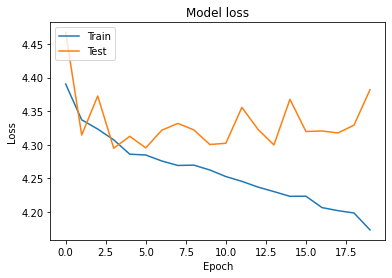

In [11]:
predictions_mlp_mid = train_baseline_mlp(x_train_mid, y_train_mid, x_test_mid, y_test_mid, x_train_target_mid, x_test_target_mid, x_scaler_mid)

In [12]:
predictions_mlp_mid.head(10)

,predicted_total_points_next_gameweek,name,GW,element,total_points_next_gameweek,season,assists,assists-3,assists-6,assists-all,...,opponent_next_G,opponent_next_GA,opponent_next_xG,opponent_next_NPxG,opponent_next_xGA,opponent_next_NPxGA,opponent_next_NPxGD,opponent_next_DC,opponent_next_ODC,opponent_next_xPTS
53413,9.361035,Mohamed Salah,25,233,10.0,2021-22,0.0,0.000000,0.000000,0.416667,...,0.857143,2.285714,0.524286,0.524286,2.240000,1.772857,-1.248571,3.285714,10.000000,0.525714
41877,8.135706,Kevin De Bruyne,19,272,0.0,2020-21,0.0,0.666667,0.666667,0.555556,...,0.900000,2.500000,0.808000,0.656000,2.231000,2.155000,-1.499000,3.600000,10.700000,0.546000
42883,7.916667,Bruno Miguel Borges Fernandes,23,302,9.0,2020-21,0.0,0.666667,0.500000,0.478261,...,0.833333,2.583333,0.806667,0.679167,2.026667,1.963333,-1.283333,2.583333,10.500000,0.642500
26616,7.730059,Mohamed_Salah_253,32,253,6.0,2018-19,1.0,0.666667,0.333333,0.312500,...,1.285714,1.285714,1.111429,1.111429,1.500000,1.282857,-0.171429,5.714286,8.142857,1.190000
20418,7.714201,Mohamed_Salah_253,5,253,8.0,2018-19,0.0,0.000000,0.400000,0.400000,...,1.200000,1.200000,1.734000,1.430000,1.654000,1.502000,-0.072000,5.200000,5.000000,1.388000
47078,7.673397,Mohamed Salah,37,254,6.0,2020-21,0.0,0.000000,0.166667,0.135135,...,1.250000,2.125000,1.102500,1.007500,1.865000,1.865000,-0.857500,6.125000,8.000000,0.968750
52242,7.337040,Mohamed Salah,21,233,0.0,2021-22,0.0,0.000000,0.166667,0.500000,...,1.222222,1.555556,1.146667,0.977778,1.273333,1.188889,-0.211111,5.777778,6.111111,1.255556
45728,7.229722,Mohamed Salah,33,254,6.0,2020-21,0.0,0.000000,0.000000,0.121212,...,1.285714,2.142857,1.520000,1.194286,1.698571,1.372857,-0.178571,6.428571,7.428571,1.241429
30452,7.177799,Mohamed_Salah_191,10,191,2.0,2019-20,0.0,0.000000,0.166667,0.300000,...,1.571429,1.571429,1.708571,1.578571,1.787143,1.678571,-0.100000,5.571429,11.000000,1.340000
25760,7.152712,Mohamed_Salah_253,28,253,3.0,2018-19,0.0,0.000000,0.000000,0.285714,...,1.000000,1.125000,1.035000,1.035000,1.272500,1.177500,-0.142500,5.750000,5.625000,1.266250


Epoch 1/20
631/631 [==============================] - 1s 1ms/step - loss: 5.3909 - val_loss: 5.3546
Epoch 2/20
631/631 [==============================] - 1s 943us/step - loss: 5.2649 - val_loss: 5.3575
Epoch 3/20
631/631 [==============================] - 1s 856us/step - loss: 5.2149 - val_loss: 5.3931
Epoch 4/20
631/631 [==============================] - 1s 862us/step - loss: 5.1609 - val_loss: 5.3430
Epoch 5/20
631/631 [==============================] - 1s 824us/step - loss: 5.1716 - val_loss: 5.4907
Epoch 6/20
631/631 [==============================] - 1s 873us/step - loss: 5.1293 - val_loss: 5.4159
Epoch 7/20
631/631 [==============================] - 1s 837us/step - loss: 5.1364 - val_loss: 5.3937
Epoch 8/20
631/631 [==============================] - 1s 861us/step - loss: 5.1153 - val_loss: 5.3710
Epoch 9/20
631/631 [==============================] - 1s 846us/step - loss: 5.0970 - val_loss: 5.4182
Epoch 10/20
631/631 [==============================] - 1s 869us/step - loss: 5.0980 

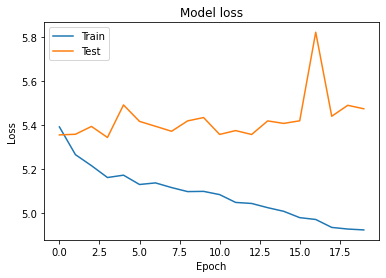

In [13]:
predictions_mlp_fwd = train_baseline_mlp(x_train_fwd, y_train_fwd, x_test_fwd, y_test_fwd, x_train_target_fwd, x_test_target_fwd, x_scaler_fwd)

In [14]:
predictions_mlp_fwd.head(10)

,predicted_total_points_next_gameweek,name,GW,element,total_points_next_gameweek,season,assists,assists-3,assists-6,assists-all,...,opponent_next_G,opponent_next_GA,opponent_next_xG,opponent_next_NPxG,opponent_next_xGA,opponent_next_NPxGA,opponent_next_NPxGD,opponent_next_DC,opponent_next_ODC,opponent_next_xPTS
6166,7.614960,Pierre-Emerick_Aubameyang,32,616,6.0,2017-18,0.0,0.333333,0.166667,0.166667,...,0.666667,1.833333,0.740000,0.740000,1.285000,1.285000,-0.545000,4.500000,6.000000,0.898333
7246,7.340843,Romelu_Lukaku_306,7,306,2.0,2018-19,0.0,0.000000,0.000000,0.000000,...,0.571429,1.428571,0.618571,0.510000,1.554286,1.337143,-0.827143,3.285714,7.142857,0.645714
6247,7.133122,Romelu_Lukaku,33,285,2.0,2017-18,0.0,0.333333,0.333333,0.218750,...,0.714286,2.142857,0.992857,0.992857,1.345714,1.345714,-0.352857,6.142857,5.428571,1.147143
31,7.098709,Harry_Kane,1,403,5.0,2016-17,0.0,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.990000,0.990000,0.680000,0.680000,0.310000,4.000000,5.000000,1.620000
12837,7.056695,Harry_Kane_338,46,338,9.0,2019-20,0.0,0.000000,0.000000,0.054054,...,0.500000,2.125000,0.712500,0.712500,1.655000,1.655000,-0.942500,4.500000,6.625000,0.782500
5397,6.931427,Harry_Kane,23,394,8.0,2017-18,0.0,0.000000,0.000000,0.043478,...,1.166667,1.916667,1.054167,1.054167,1.515000,1.515000,-0.460833,5.083333,10.250000,1.080833
5059,6.850109,Sergio_Agüero,19,257,2.0,2017-18,1.0,0.333333,0.166667,0.210526,...,0.900000,2.100000,0.852000,0.852000,1.705000,1.552000,-0.700000,4.000000,9.600000,0.806000
13142,6.744313,Danny Ings,3,366,2.0,2020-21,0.0,0.000000,0.000000,0.000000,...,1.666667,3.666667,0.526667,0.526667,3.160000,2.653333,-2.126667,5.000000,7.000000,0.156667
7070,6.611692,Pierre-Emerick_Aubameyang_23,4,23,5.0,2018-19,0.0,0.000000,0.000000,0.000000,...,0.750000,1.500000,0.822500,0.632500,1.925000,1.735000,-1.102500,4.000000,7.000000,0.647500
930,6.603570,Harry_Kane,11,403,13.0,2016-17,0.0,0.000000,0.000000,0.090909,...,1.000000,1.875000,1.086250,0.991250,1.650000,1.460000,-0.468750,5.250000,4.750000,0.981250


## Train on baseline XGBoost models

In [19]:
def train_baseline_xgb(x_train, y_train, x_test, y_test, x_train_target, x_test_target, x_scaler):
    model_xgb = xgb.XGBRegressor()
    model_xgb.fit(x_train, y_train)

    # create series to keep indexes and name same as in the original y data
    y_pred_xgb = pd.Series(model_xgb.predict(x_test), index=y_test.index,
                           name='predicted_total_points_next_gameweek')

    x_test_reversed = reverse_processing(x_test, x_scaler, x_test_target)
    predictions_xgb = pd.concat([y_pred_xgb, x_test_reversed], axis=1)
    #preview predictions_xgb sorted by predicted total points descending
    print(mean_squared_error(y_pred_xgb, y_test))

    return predictions_xgb.sort_values(by='predicted_total_points_next_gameweek', ascending=False)

In [20]:
predictions_xgb_gk = train_baseline_xgb(x_train_gk, y_train_gk, x_test_gk, y_test_gk, x_train_target_gk, x_test_target_gk, x_scaler_gk)

3.1491762980915836


In [21]:
predictions_xgb_gk.head(10)

,predicted_total_points_next_gameweek,name,GW,element,total_points_next_gameweek,season,bonus,bonus-3,bonus-6,bonus-all,...,opponent_next_G,opponent_next_GA,opponent_next_xG,opponent_next_NPxG,opponent_next_xGA,opponent_next_NPxGA,opponent_next_NPxGD,opponent_next_DC,opponent_next_ODC,opponent_next_xPTS
5357,8.355724,Ederson_Santana de Moraes_260,11,260,2.0,2018-19,0.0,0.666667,0.500000,0.363636,...,1.857143,1.571429,1.780000,1.657143,1.567143,1.458571,0.198571,8.000000,8.142857,1.482857
9967,7.764340,Alisson Ramses Becker,7,252,2.0,2020-21,0.0,0.000000,0.333333,0.285714,...,1.500000,1.333333,1.526667,1.400000,1.325000,0.945000,0.455000,8.833333,3.166667,1.610000
8898,7.661096,Kepa_Arrizabalaga_111,29,111,3.0,2019-20,0.0,0.000000,0.000000,0.000000,...,1.000000,2.714286,1.068571,0.960000,2.698571,2.460000,-1.500000,4.571429,8.571429,0.468571
9621,7.602819,Jordan Pickford,1,157,1.0,2020-21,1.0,1.000000,1.000000,1.000000,...,0.000000,3.000000,0.350000,0.350000,2.960000,1.430000,-1.080000,6.000000,3.000000,0.060000
2385,7.549697,Robert_Elliot,1,286,2.0,2017-18,0.0,0.000000,0.000000,0.000000,...,3.000000,0.000000,1.740000,1.740000,0.990000,0.990000,0.750000,5.000000,3.000000,2.040000
2189,7.475173,Lukasz_Fabianski,37,356,0.0,2016-17,1.0,0.333333,0.500000,0.216216,...,0.625000,1.125000,1.071250,1.071250,1.038750,1.038750,0.032500,5.375000,7.875000,1.372500
9945,7.270217,Vicente Guaita,7,128,2.0,2020-21,0.0,0.000000,0.000000,0.428571,...,2.000000,1.500000,1.536667,1.408333,1.630000,1.248333,0.160000,8.000000,8.833333,1.410000
11216,7.246091,Ederson Santana de Moraes,24,278,6.0,2020-21,0.0,0.666667,0.333333,0.125000,...,1.900000,0.700000,1.705000,1.553000,1.084000,0.932000,0.621000,7.600000,4.400000,1.689000
10827,7.245644,Emiliano MartÃ­nez,19,12,1.0,2020-21,0.0,0.000000,0.333333,0.555556,...,0.600000,1.000000,0.813000,0.737000,1.691000,1.539000,-0.802000,5.100000,9.500000,0.755000
12955,7.190502,Alisson Ramses Becker,10,231,-1.0,2021-22,0.0,0.000000,0.166667,0.400000,...,1.428571,0.857143,1.740000,1.631429,1.042857,1.042857,0.588571,5.714286,4.714286,1.878571


In [22]:
predictions_xgb_def = train_baseline_xgb(x_train_def, y_train_def, x_test_def, y_test_def, x_train_target_def, x_test_target_def, x_scaler_def)

4.881946248012564


In [23]:
predictions_xgb_def.head(10)

,predicted_total_points_next_gameweek,name,GW,element,total_points_next_gameweek,season,assists,assists-3,assists-6,assists-all,...,opponent_next_G,opponent_next_GA,opponent_next_xG,opponent_next_NPxG,opponent_next_xGA,opponent_next_NPxGA,opponent_next_NPxGD,opponent_next_DC,opponent_next_ODC,opponent_next_xPTS
40650,13.900408,Benjamin Chilwell,9,135,8.0,2021-22,0.0,0.000000,0.000000,0.000000,...,1.285714,2.000000,1.107143,1.107143,1.932857,1.824286,-0.718571,4.142857,8.428571,0.831429
42313,11.599317,Aymeric Laporte,17,259,6.0,2021-22,0.0,0.000000,0.000000,0.000000,...,1.000000,2.100000,0.770000,0.694000,1.859000,1.631000,-0.937000,3.500000,9.400000,0.699000
147,11.103292,Héctor_Bellerín,1,6,9.0,2016-17,0.0,0.000000,0.000000,0.000000,...,1.000000,2.000000,2.460000,1.700000,0.740000,0.740000,0.960000,5.000000,0.000000,2.590000
44708,10.761583,Tyrone Mings,28,38,8.0,2021-22,0.0,0.333333,0.166667,0.115385,...,1.000000,3.000000,1.512500,1.512500,2.296250,2.106250,-0.593750,8.250000,8.875000,1.165000
44216,9.992251,JoÃ£o Pedro Cavaco Cancelo,26,256,9.0,2021-22,0.0,0.000000,0.166667,0.307692,...,1.166667,1.833333,1.203333,1.075000,1.500000,1.500000,-0.425000,5.333333,5.500000,1.218333
40647,9.403612,Trevoh Chalobah,9,527,0.0,2021-22,0.0,0.000000,0.000000,0.000000,...,1.285714,2.000000,1.107143,1.107143,1.932857,1.824286,-0.718571,4.142857,8.428571,0.831429
3438,9.383092,Kyle_Walker,18,384,0.0,2016-17,0.0,0.666667,0.333333,0.222222,...,1.000000,2.125000,0.941250,0.846250,1.582500,1.391250,-0.545000,4.375000,6.500000,0.991250
7692,9.300927,Ryan_Bertrand,1,307,1.0,2017-18,0.0,0.000000,0.000000,0.000000,...,0.000000,4.000000,0.630000,0.630000,2.640000,2.640000,-2.010000,9.000000,10.000000,0.230000
44949,8.859852,Trent Alexander-Arnold,29,237,7.0,2021-22,0.0,0.333333,0.166667,0.392857,...,1.666667,0.666667,1.796667,1.670000,0.771667,0.771667,0.898333,10.833333,4.166667,2.105000
33462,8.567935,Trent Alexander-Arnold,15,259,6.0,2020-21,0.0,0.333333,0.166667,0.133333,...,1.125000,1.750000,1.033750,0.843750,1.547500,1.547500,-0.705000,3.500000,9.250000,1.125000


In [30]:
predictions_xgb_mid = train_baseline_xgb(x_train_mid, y_train_mid, x_test_mid, y_test_mid, x_train_target_mid, x_test_target_mid, x_scaler_mid)

4.638671892398152


In [31]:
predictions_xgb_mid.head(10)

,predicted_total_points_next_gameweek,name,GW,element,total_points_next_gameweek,season,assists,assists-3,assists-6,assists-all,...,opponent_next_G,opponent_next_GA,opponent_next_xG,opponent_next_NPxG,opponent_next_xGA,opponent_next_NPxGA,opponent_next_NPxGD,opponent_next_DC,opponent_next_ODC,opponent_next_xPTS
36095,12.863020,Sadio_ManÃ©_192,42,192,0.0,2019-20,0.0,0.000000,0.166667,0.272727,...,0.750000,1.000000,0.747500,0.557500,0.740000,0.740000,-0.182500,4.250000,7.500000,1.397500
37158,11.644796,Raheem_Sterling_214,46,214,8.0,2019-20,1.0,0.333333,0.666667,0.162162,...,0.125000,2.250000,0.515000,0.515000,1.825000,1.825000,-1.310000,3.625000,8.000000,0.623750
11033,10.476795,Kevin_De Bruyne,5,252,3.0,2017-18,1.0,1.000000,0.600000,0.600000,...,0.000000,1.600000,1.260000,1.260000,1.420000,1.420000,-0.160000,6.600000,6.400000,1.312000
11591,10.464882,David_Silva,7,248,7.0,2017-18,0.0,1.333333,0.833333,0.857143,...,1.000000,1.571429,1.058571,0.950000,1.521429,1.521429,-0.572857,6.285714,7.571429,1.008571
13350,10.394787,Willian_Borges Da Silva,15,106,1.0,2017-18,0.0,0.000000,0.000000,0.133333,...,0.750000,2.375000,0.875000,0.780000,1.800000,1.502500,-0.722500,4.250000,9.125000,0.793750
41877,10.254735,Kevin De Bruyne,19,272,0.0,2020-21,0.0,0.666667,0.666667,0.555556,...,0.900000,2.500000,0.808000,0.656000,2.231000,2.155000,-1.499000,3.600000,10.700000,0.546000
30375,10.138658,Christian_Pulisic_431,10,431,9.0,2019-20,0.0,0.333333,0.166667,0.300000,...,0.571429,2.000000,1.187143,1.078571,1.712857,1.604286,-0.524286,5.428571,6.428571,1.415714
47682,10.026699,Jack Grealish,2,33,6.0,2021-22,0.0,0.000000,0.000000,0.000000,...,0.000000,2.000000,0.825000,0.825000,2.765000,2.765000,-1.940000,6.500000,13.000000,0.360000
34994,10.001240,Kevin_De Bruyne_215,29,215,0.0,2019-20,0.0,0.333333,0.333333,0.642857,...,1.714286,0.857143,1.518571,1.518571,1.795714,1.687143,-0.168571,6.857143,6.571429,1.312857
43684,9.853478,Kevin De Bruyne,26,272,2.0,2020-21,1.0,0.333333,0.166667,0.423077,...,1.200000,1.200000,1.158000,0.929000,1.387000,1.159000,-0.230000,3.100000,7.200000,1.236000


In [32]:
predictions_xgb_fwd = train_baseline_xgb(x_train_fwd, y_train_fwd, x_test_fwd, y_test_fwd, x_train_target_fwd, x_test_target_fwd, x_scaler_fwd)

5.72651565642211


In [33]:
predictions_xgb_fwd.head(10)

,predicted_total_points_next_gameweek,name,GW,element,total_points_next_gameweek,season,assists,assists-3,assists-6,assists-all,...,opponent_next_G,opponent_next_GA,opponent_next_xG,opponent_next_NPxG,opponent_next_xGA,opponent_next_NPxGA,opponent_next_NPxGD,opponent_next_DC,opponent_next_ODC,opponent_next_xPTS
5495,13.768735,Sergio_Agüero,24,257,6.0,2017-18,0.0,0.333333,0.333333,0.208333,...,0.833333,1.083333,1.088333,1.025000,1.128333,1.128333,-0.103333,3.833333,5.916667,1.335000
3772,13.114183,Harry_Kane,2,394,2.0,2017-18,0.0,0.000000,0.000000,0.000000,...,1.500000,1.500000,0.970000,0.970000,1.005000,1.005000,-0.035000,3.500000,2.000000,1.315000
3843,11.508530,Harry_Kane,3,394,13.0,2017-18,0.0,0.000000,0.000000,0.000000,...,0.666667,1.000000,0.550000,0.550000,0.863333,0.863333,-0.313333,2.666667,11.333333,1.080000
5691,11.171268,Harry_Kane,27,394,6.0,2017-18,0.0,0.000000,0.000000,0.037037,...,1.300000,1.400000,1.585000,1.281000,1.291000,1.215000,0.066000,5.800000,8.600000,1.695000
5945,11.169832,Sergio_Agüero,29,257,0.0,2017-18,0.0,0.333333,0.166667,0.206897,...,0.714286,1.000000,0.835714,0.727143,1.120000,1.120000,-0.392857,5.142857,7.428571,1.134286
18188,10.892094,Harry Kane,26,357,2.0,2021-22,0.0,0.000000,0.166667,0.086957,...,0.857143,1.142857,0.820000,0.820000,1.482857,1.482857,-0.661429,3.714286,8.571429,0.848571
11589,10.428970,Sergio_AgÃ¼ero_210,22,210,13.0,2019-20,1.0,0.333333,0.166667,0.181818,...,1.000000,0.800000,0.792000,0.792000,1.399000,1.399000,-0.606000,6.700000,7.700000,0.869000
2203,10.272902,Zlatan_Ibrahimovic,24,272,5.0,2016-17,0.0,0.000000,0.166667,0.208333,...,1.100000,1.600000,1.030000,0.954000,1.434000,1.282000,-0.328000,4.400000,6.400000,1.079000
4822,9.774372,Harry_Kane,16,394,2.0,2017-18,0.0,0.000000,0.000000,0.062500,...,1.000000,1.333333,0.987778,0.817778,1.284444,1.200000,-0.382222,3.333333,6.000000,1.153333
2157,9.479401,Romelu_Lukaku,24,143,2.0,2016-17,0.0,0.000000,0.166667,0.166667,...,0.600000,1.200000,0.738000,0.586000,1.460000,1.384000,-0.798000,3.300000,8.200000,0.915000


## Conclusion #1
It's hard to comare these models now, only looking at mean_square_error metric. In case of smaller datasets, MLP model seems to be overfitting, and can be worse than XGBoost model in this case (MLP seems to be better when datasets aren't separated by positions). But to compare models, we need to look at the predictions and evaluate it as I did before, when getting squad without constrains, what I will do in the next notebook.